# Notebooks to merge subject information from imaging, clinical assessments and other sources of data

In [2]:
# from pathlib import Path
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd

#PATH
main_dir = Path("/scratch/mr_proc")
out_dir = Path("/output")
data_dir = main_dir / 'tab_data' 

#ppmi_dcm_file = data_dir / 'ppmi_dicomInfo.tsv'           # Inormation from dicom headers.
ppmi_img_dl_file = data_dir / 'PPMI_3T_sdMRI_3_07_2022.csv'  # Inormation from download database.
ppmi_moca_file  = data_dir / 'Montreal_Cognitive_Assessment__MoCA_.csv'  # Inormation from download database.
ppmi_updrs3_file  = data_dir / 'MDS_UPDRS_Part_III.csv'  # Inormation from download database.

# Read table
#ppmi_dcm_data = pd.read_csv(ppmi_dcm_file, sep='\t')
ppmi_img_dl_data  = pd.read_csv(ppmi_img_dl_file, sep=',')
ppmi_img_col_sel = ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description']
ppmi_img_dl_data = ppmi_img_dl_data.loc[:, ppmi_img_col_sel].copy()
ppmi_updrs3_data  = pd.read_csv(ppmi_updrs3_file, sep=',')
ppmi_moca_data  = pd.read_csv(ppmi_moca_file, sep=',')

/usr/local/miniconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (10,17,18,19,20,21,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Visit counts: 1    253
2    119
4    109
3    103
5      1
Name: Visit, dtype: int64
{PD}              304
{Prodromal}       145
{Control}          91
{SWEDD}            42
{Phantom}           2
{GenReg Unaff}      1
Name: Group, dtype: int64


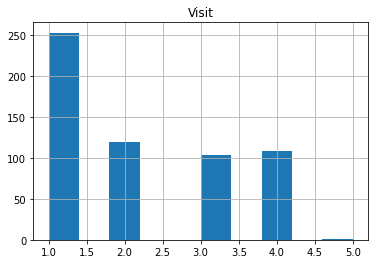

In [6]:
# Read table
#data selection
tmp_data = ppmi_img_dl_data
grouped=tmp_data.groupby(by='Subject').agg(lambda x: len(set(x)))
grouped.hist(column=['Visit'])
print('Visit counts:', grouped.Visit.value_counts())
print(tmp_data.groupby(by='Subject').agg(lambda x: set(x)).Group.value_counts())

In [9]:
tmp_data.groupby(by='Subject').agg(lambda x: list(x)).value_counts('Visit')

TypeError: unhashable type: 'list'

In [3]:
ppmi_moca_data

,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,MCAALTTM,MCACUBE,MCACLCKC,MCACLCKN,MCACLCKH,...,MCAREC5,MCADATE,MCAMONTH,MCAYR,MCADAY,MCAPLACE,MCACITY,MCATOT,ORIG_ENTRY,LAST_UPDATE
0,269556101,3000,SC,MOCA,01/2011,1,1,1,1,1,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,27.0,01/2011,2020-06-25 16:02:21.0
1,338704501,3000,V04,MOCA,03/2012,1,1,1,1,1,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0,03/2012,2020-06-25 16:02:21.0
2,385012501,3000,V06,MOCA,02/2013,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.0,02/2013,2020-06-25 16:02:22.0
3,437134401,3000,V08,MOCA,03/2014,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,05/2014,2020-06-25 16:02:22.0
4,512480201,3000,V10,MOCA,03/2015,1,1,1,1,1,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,29.0,03/2015,2020-06-25 16:02:23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8352,706e009e-4578-4ac5-a910-37dd34c8e39a,137450,SC,MOCA,01/2022,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,27.0,02/2022,2022-02-09 00:00:00.0
8353,462679ca-5e59-407a-815c-a4bfaa337417,138024,SC,MOCA,01/2022,0,0,1,1,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.0,02/2022,2022-02-10 00:00:00.0
8354,7a0b0505-71a1-45ec-aac9-19cf48c8b272,139750,SC,MOCA,02/2022,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,26.0,02/2022,2022-02-09 00:00:00.0
8355,da678dfc-9bd4-49a7-85ec-5dc39bef3e4a,140451,SC,MOCA,02/2022,1,1,1,1,1,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,26.0,02/2022,2022-02-17 00:00:00.0


In [4]:
ppmi_updrs3_data

,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,PDMEDDT,PDMEDTM,PDSTATE,EXAMTM,DBS_STATUS,...,DYSKIRAT,NHY,PDTRTMNT,DBSONTM,DBSOFFTM,HRPOSTMED,HRDBSOFF,HRDBSON,ORIG_ENTRY,LAST_UPDATE
0,272451901,3000,BL,NUPDRS3,02/2011,NaN,NaN,NaN,13:17:00,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,02/2011,2020-06-25 16:02:19.0
1,338703101,3000,V04,NUPDRS3,03/2012,NaN,NaN,NaN,13:47:00,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,03/2012,2020-06-25 16:02:22.0
2,385009801,3000,V06,NUPDRS3,02/2013,NaN,NaN,NaN,12:22:00,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,02/2013,2020-06-25 16:02:22.0
3,437131401,3000,V08,NUPDRS3,03/2014,NaN,NaN,NaN,13:22:00,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,05/2014,2020-06-25 16:02:22.0
4,512469901,3000,V10,NUPDRS3,03/2015,NaN,NaN,NaN,11:43:00,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,03/2015,2020-06-25 16:02:23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17615,064d32c1-3649-4516-9ed0-c21a65bdccb3,121830,BL,NUPDRS3,01/2022,NaN,NaN,NaN,NaN,NaN,...,0.0,2,0.0,NaN,NaN,NaN,NaN,NaN,01/2022,2022-01-17 00:00:00.0
17616,9bd3731e-b1ff-424f-8ac0-88458c8563e0,124793,BL,NUPDRS3,02/2022,NaN,NaN,NaN,NaN,NaN,...,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN,02/2022,2022-02-10 00:00:00.0
17617,93517324-d1b7-4eaf-970b-0677a46876a3,130013,BL,NUPDRS3,02/2022,NaN,NaN,NaN,NaN,NaN,...,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN,02/2022,2022-02-09 00:00:00.0
17618,2c9e252a-70b6-4636-9eb7-c821bb92bc93,130190,BL,NUPDRS3,02/2022,NaN,NaN,NaN,NaN,NaN,...,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,02/2022,2022-02-17 00:00:00.0


In [5]:
ppmi_img_dl_data

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I951927,85242,Prodromal,M,66,7,MRI,MPRAGE_GRAPPA_ADNI,Original,2/08/2017,DCM,2/11/2022
1,I482363,85242,Prodromal,M,64,1,DTI,DTI_gated,Original,2/18/2015,DCM,2/10/2022
2,I951930,85242,Prodromal,M,66,7,DTI,DTI_gated,Original,2/08/2017,DCM,2/10/2022
3,I643421,85242,Prodromal,M,65,5,MRI,AXIAL PD-T2 TSE FS,Original,2/03/2016,DCM,2/10/2022
4,I482361,85242,Prodromal,M,64,1,MRI,MPRAGE_GRAPPA,Original,2/18/2015,DCM,2/10/2022
...,...,...,...,...,...,...,...,...,...,...,...,...
5948,I253663,08827APR11,Phantom,M,39,1,DTI,DTI_TRACEW,Original,4/27/2011,DCM,2/17/2022
5949,I253665,08827APR11,Phantom,M,39,1,DTI,DTI_EXP,Original,4/27/2011,DCM,2/17/2022
5950,I253667,08827APR11,Phantom,M,39,1,DTI,DTI,Original,4/27/2011,DCM,2/17/2022
5951,I787959,01218AUG16,Phantom,X,56,0,MRI,MPRAGE Phantom GRAPPA2,Original,8/18/2016,DCM,2/10/2022


In [ ]:
"